In [1]:
# Lawyer Data after filtering out the canadian states and concatenating the CBG
Data = spark.read.parquet("/tmp/Litigation/Lawywer_filtered_data.parquet")

In [4]:
# reading the CBG, lawyer and PA_claims table from the Data Frame
cbg_Lawyer_PA = spark.read.parquet("/tmp/Litigation/check_point_1.parquet")

In [6]:
# to filter out the newyork city county alone to check the lawyer count distribution
cbg_Lawyer_PA.createOrReplaceTempView('df')
test_nyc = spark.sql(" select GEOID10,LAWYER_COUNT,PA_Claimed from df where GEOID10 LIKE ('__005%') OR GEOID10 LIKE ('__047%') OR GEOID10 LIKE ('__061%') OR GEOID10 LIKE ('__081%') OR GEOID10 LIKE ('__085%') ")
# display(test_nyc)

In [7]:
# number of rows in the above table 
cbg_Lawyer_PA.cache().count()

Out[ 5 ]: 66847

In [8]:
# pdf stands for pandas dataframe
# converting it into a pandas DF so we can merge it into the shape file
cbg_Lawyer_PA_PDF = cbg_Lawyer_PA.toPandas()

In [9]:
# loading the shape file
import geopandas as gpd
shp_cbg = gpd.read_file("/dbfs/mnt/db_databricks/visc-cs/cluster_template/ShapeFiles/US_CBG/US_CBG_2010.shp")
shp_cbg.head()

Out[ 7 ]: 
 STATEFP10 ... geometry
0 48 ... POLYGON ((-308785.67909722 -613446.1132360073,...
1 48 ... POLYGON ((-491689.4390917541 -795684.676935371...
2 48 ... POLYGON ((-484001.3289504145 -795355.505693951...
3 48 ... POLYGON ((-486652.4357499366 -796628.433303061...
4 48 ... POLYGON ((-488454.3900402897 -795969.853998947...

[5 rows x 14 columns]

In [10]:
# merging the shape file and Lawyer_count and PA_claimed with CBG (GEOID10) as common column
import pandas as pd
shp_cbg_duplicate = pd.merge(shp_cbg,cbg_Lawyer_PA_PDF,on='GEOID10', how='left')
shp_cbg_duplicate = shp_cbg_duplicate.fillna(0)

In [11]:
shp_cbg_duplicate

Out[ 9 ]: 
 STATEFP10 COUNTYFP10 ... LAWYER_COUNT PA_Claimed
0 48 155 ... 0.0 0.0
1 48 227 ... 0.0 0.0
2 48 227 ... 0.0 0.0
3 48 227 ... 0.0 0.0
4 48 227 ... 0.0 0.0
5 48 227 ... 0.0 0.0
6 48 227 ... 0.0 0.0
7 48 227 ... 0.0 0.0
8 48 227 ... 0.0 0.0
9 48 227 ... 0.0 0.0
10 48 227 ... 6.0 13.0
11 48 227 ... 0.0 0.0
12 48 227 ... 0.0 0.0
13 48 153 ... 0.0 0.0
14 48 153 ... 0.0 0.0
15 48 153 ... 0.0 0.0
16 48 153 ... 0.0 0.0
17 48 153 ... 0.0 0.0
18 48 227 ... 0.0 0.0
19 48 227 ... 38.0 89.0
20 48 227 ... 0.0 0.0
21 48 227 ... 0.0 0.0
22 48 227 ... 0.0 0.0
23 48 227 ... 0.0 0.0
24 48 227 ... 0.0 0.0
25 48 227 ... 0.0 0.0
26 48 227 ... 0.0 0.0
27 48 227 ... 0.0 0.0
28 48 227 ... 0.0 0.0
29 48 227 ... 0.0 0.0
... ... ... ... ... ...
217710 02 020 ... 0.0 0.0
217711 02 020 ... 0.0 0.0
217712 02 020 ... 1.0 1.0
217713 02 020 ... 0.0 0.0
217714 02 020 ... 0.0 0.0
217715 02 020 ... 0.0 0.0
217716 02 020 ... 0.0 0.0
217717 02 020 ... 0.0 0.0
217718 02 020 ... 0.0 0.0
217719 02 020 ... 0.0 0.0
217720 02 020 ... 0.0 0.0
217721 02 020 ... 0.0 0.0
217722 02 020 ... 0.0 0.0
217723 02 020 ... 3.0 3.0
217724 02 020 ... 4.0 5.0
217725 02 020 ... 6.0 11.0
217726 02 020 ... 0.0 0.0
217727 02 020 ... 0.0 0.0
217728 02 020 ... 0.0 0.0
217729 02 020 ... 0.0 0.0
217730 02 020 ... 0.0 0.0
217731 02 020 ... 0.0 0.0
217732 02 020 ... 0.0 0.0
217733 02 020 ... 0.0 0.0
217734 02 020 ... 0.0 0.0
217735 02 020 ... 0.0 0.0
217736 02 020 ... 12.0 24.0
217737 02 020 ... 0.0 0.0
217738 02 020 ... 41.0 306.0
217739 02 020 ... 1.0 1.0

[217740 rows x 16 columns]

In [12]:
# retrieving the last three columns alone which we need 
lawyer_PA_array = shp_cbg_duplicate.as_matrix(columns=shp_cbg_duplicate.columns[13:])

/local_disk0/tmp/1562938023542-0/PythonShell.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 from __future__ import print_function

In [13]:
# splitting the column into a new indivdual arrays 
polygon_array = lawyer_PA_array[:,0]
lawyer_count_array = lawyer_PA_array[:,1]
PA_claimed_array = lawyer_PA_array[:,2]

In [14]:
# these are the columns we will be passing to find hot/cold spots
y = shp_cbg_duplicate['LAWYER_COUNT']
x = shp_cbg_duplicate['PA_Claimed']
z = shp_cbg_duplicate['geometry']

In [15]:
import pysal 

In [16]:
QW = pysal.lib.weights.Queen(z)  # Rook

In [17]:
# with the polygon geometry column we can find the Queens spatial weights
# this takes time to run

qW = pysal.lib.weights.Queen(polygon_array)

# or 
# qW = pysal.lib.weights.Queen(z)

/databricks/python/lib/python3.5/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 5 disconnected observations 
 Island ids: 83747, 169721, 191722, 206964, 217382
 " Island ids: %s" % ', '.join(str(island) for island in self.islands))

In [18]:
# importing G_Local 
# this is to instead of Moran_Local (but didnt work out well)
from pysal.explore.esda.getisord import G_Local
from pysal.explore.esda.getisord import G
import pysal.lib
import numpy

In [20]:
# rounded off final p_sim value (significance level)
round(lg.p_sim[0], 3)

In [22]:
 import pysal.viz.mapclassify as mc
 import matplotlib.pyplot as plt

In [23]:
# Moran's I value method to find the spatial auto-correlation between the data
from pysal.explore.esda.moran import Moran_Local
li = Moran_Local(y, qW, transformation = "r", permutations = 999)

('WARNING: ', 83747, ' is an island (no neighbors)')
('WARNING: ', 169721, ' is an island (no neighbors)')
('WARNING: ', 191722, ' is an island (no neighbors)')
('WARNING: ', 206964, ' is an island (no neighbors)')
('WARNING: ', 217382, ' is an island (no neighbors)')
/databricks/python/lib/python3.5/site-packages/pysal/explore/esda/moran.py:895: RuntimeWarning: invalid value encountered in true_divide
 self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/databricks/python/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
 return (a < x) & (x < b)
/databricks/python/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
 return (a < x) & (x < b)
/databricks/python/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
 cond2 = (x >= _b) & cond0

In [24]:
li.q

Out[ 21 ]: array([3, 3, 3, ..., 3, 4, 3])

In [25]:
# just trying Moran instead of Moran_Local
from pysal.explore.esda.moran import Moran
#li_test = Moran(y, qW)

In [26]:
# to save the p values from Moran into a parquet file!

import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np

"""
a0 = pa.Array.from_pandas(temp_array)

t = pa.Table.from_arrays([a0], ['col0'])

pq.write_table(t, '/tmp/Litigation/test.parquet')
returned_t = pq.read_table('/tmp/Litigation/test.parquet')
"""

Out[ 21 ]: "\na0 = pa.Array.from_pandas(temp_array)\n\nt = pa.Table.from_arrays([a0], ['col0'])\n\npq.write_table(t, '/tmp/Litigation/test.parquet')\nreturned_t = pq.read_table('/tmp/Litigation/test.parquet')\n"

In [27]:
# to check how many points have P_value less than 0.1
(li_test.p_sim < 0.1).sum()

In [28]:
# defining 3 new significance levels namely (sig_1 = 0.01) (sig_2 = 0.05) and (sig_3# = 0.1)
#sig_1 = li.p_sim <0.1
#H = sig_1 * li.q == 4

sig_3 = li.p_sim < 0.1

H = sig_3

#sig_temp = li.p_sim < 0.05 
#sig_2 = sig_temp > 0.01
#doughnut = sig_2
#H.shape

import matplotlib.pyplot as plt
import numpy as np

sig = 1 * (li.p_sim < 0.5)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots



Out[ 22 ]: array([3, 3, 3, ..., 3, 4, 3])

In [29]:
# small module to check how many values are in each quadrant 
c=0
for i in range(217740):
  if(spots[i]== 1):   # quadrant number 
    c =c+1
    
print(c)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-177680> in <module> () 
 2 c = 0 
 3 for i in range ( 217740 ) : 
 ----> 4 if ( spots [ i ] == 1 ) : # quadrant number 
 5 c = c + 1 
 6 

 NameError : name 'spots' is not defined

In [30]:
spots = ['n.sig.', 'hot spot (0.1)']
labels_1 = [spots[i] for i in H*1]

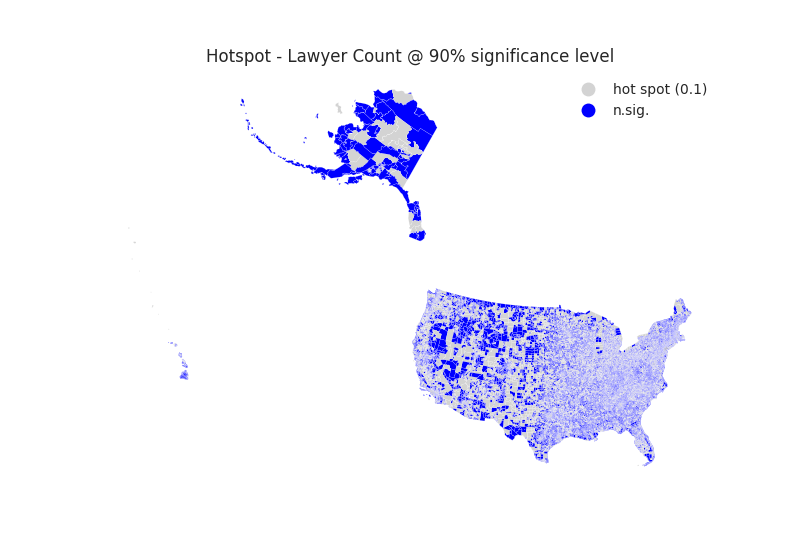

In [31]:
# plotting the hotspot in the 0.1 significance level 
df = shp_cbg_duplicate

from matplotlib import colors
hmap = colors.ListedColormap(['lightgrey', 'blue'])
fig, ax = plt.subplots(1)
df.assign(cl=labels_1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Hotspot - Lawyer Count @ 90% significance level")
display(fig)

In [32]:
sig_1 = 1*(li.p_sim < 0.01)
hotspot = sig_1

sig = 1*(li.p_sim < 0.1)
sig_3 = sig > 0.05
coldspot = sig_3

sig_temp = 1*(li.p_sim < 0.05) 
sig_2 = sig_temp > 0.01
doughnut = sig_2



hotspot = 1 * (sig_1)
coldspot = 3 * (sig_3)
doughnut = 2 * (sig_2)

spots = hotspot + coldspot + doughnut

In [33]:
spot_labels = [ 'n.sig.', '0.01', '0.05', '0.1']
labels = [spot_labels[i] for i in spots]

--------------------------------------------------------------------------- 
 IndexError Traceback (most recent call last)
 <command-174871> in <module> () 
 1 spot_labels = [ 'n.sig.' , '0.01' , '0.05' , '0.1' ] 
 ----> 2 labels = [ spot_labels [ i ] for i in spots ] 

 <command-174871> in <listcomp> (.0) 
 1 spot_labels = [ 'n.sig.' , '0.01' , '0.05' , '0.1' ] 
 ----> 2 labels = [ spot_labels [ i ] for i in spots ] 

 IndexError : list index out of range

In [34]:
hmap = colors.ListedColormap([ 'lightgrey', '#f54242', '#803737', '#b07d7d'])
figure, ax = plt.subplots(1)
shp_cbg_duplicate.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
display(figure)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-174877> in <module> () 
 1 hmap = colors . ListedColormap ( [ 'lightgrey' , '#f54242' , '#803737' , '#b07d7d' ] ) 
 2 figure , ax = plt . subplots ( 1 ) 
 ----> 3 shp_cbg_duplicate . assign ( cl = labels ) . plot ( column = 'cl' , categorical = True , k = 2 , cmap = hmap , linewidth = 0.1 , ax = ax , edgecolor = 'white' , legend = True ) 
 4 ax . set_axis_off ( ) 
 5 display ( figure ) 

 NameError : name 'labels' is not defined

In [35]:
# Testing the hotspot for PA_Cliamed instead of LAwyer_count
# Moran's I value method to find the spatial auto-correlation between the data
from pysal.explore.esda.moran import Moran_Local
li_x = Moran_Local(x, qW, transformation = "r", permutations = 999)

In [36]:
significance = li_x.p_sim < 0.01
hotspot_x = significance

In [37]:
spots = ['n.sig.', 'hot spot (0.01)']
labels_1 = [spots[i] for i in hotspot_x*1]

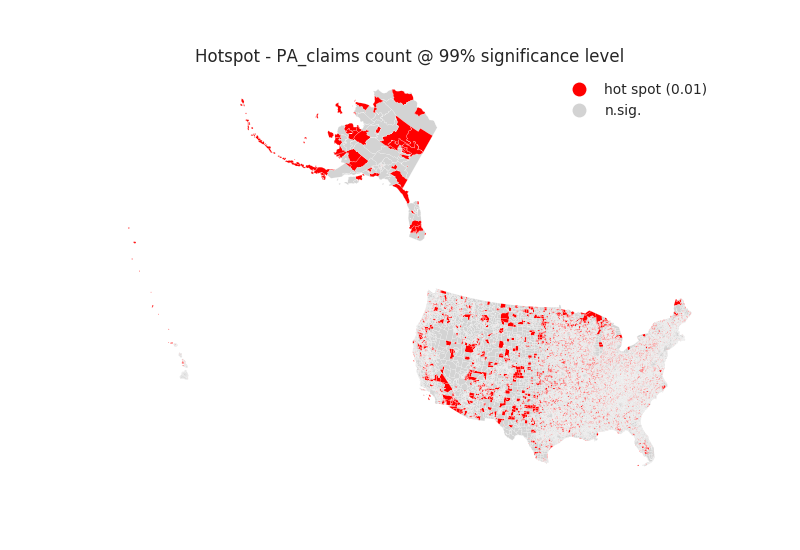

In [38]:
# plotting the hotspot in the 0.01 significance level 
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
fig, ax = plt.subplots(1)
shp_cbg_duplicate.assign(cl=labels_1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Hotspot - PA_claims count @ 99% significance level")
display(fig)

In [39]:
# trying Rook for the hotspot instead of Queen weights

# with the polygon geometry column we can find the Rook spatial weights
import pysal
rW = pysal.lib.weights.Rook(polygon_array)

/databricks/python/lib/python3.5/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 5 disconnected observations 
 Island ids: 83747, 169721, 191722, 206964, 217382
 " Island ids: %s" % ', '.join(str(island) for island in self.islands))

In [40]:
li_r = Moran_Local(y, rW)

('WARNING: ', 83747, ' is an island (no neighbors)')
('WARNING: ', 169721, ' is an island (no neighbors)')
('WARNING: ', 191722, ' is an island (no neighbors)')
('WARNING: ', 206964, ' is an island (no neighbors)')
('WARNING: ', 217382, ' is an island (no neighbors)')

In [41]:
significance_level = li_r.p_sim < 0.1
hotspot_r = significance_level 

In [42]:
spots = ['n.sig.', 'hot spot (0.1)']
labels_r = [spots[i] for i in hotspot_r*1]

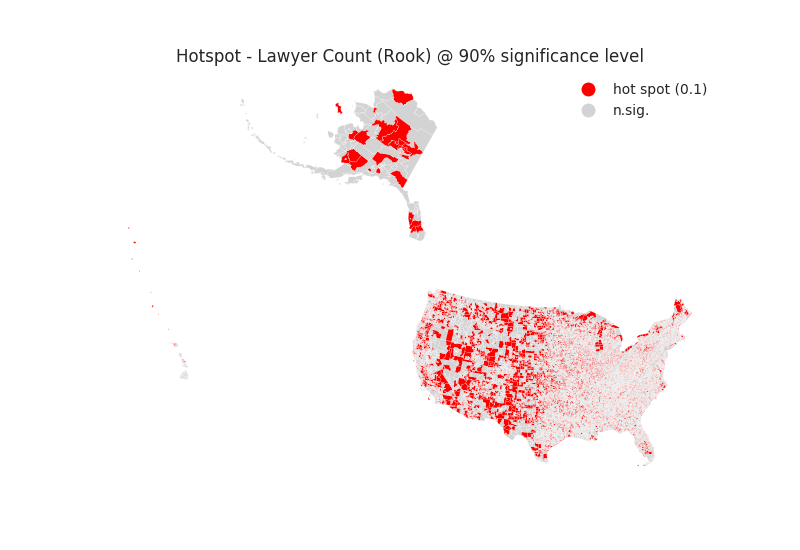

In [43]:
# plotting the hotspot in the 0.01 significance level 
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
fig, ax = plt.subplots(1)
shp_cbg_duplicate.assign(cl=labels_r).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Hotspot - Lawyer Count (Rook) @ 90% significance level")
display(fig)